In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

%matplotlib inline

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Our device is {device}")

Our device is cpu


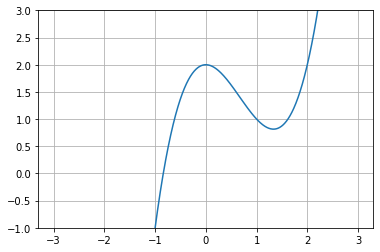

In [3]:
# Optimize one param - function in Pythorch
# min_O L(p_O(X), Y)
# L - loss
# p_O - neural network
# X - data of train
# Y - answers

# function
func = lambda x: x ** 3 - 2 * x ** 2 + 2
# differencial
d_func = lambda x: 3 * x ** 2 - 4 * x

x = np.linspace(-3, 3, 1000)
plt.figure(figsize=(6, 4))
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

In [20]:
def find_minimum_first_order(
        learning_rate = 0.01,
        eps = 1e-4,
        max_iterations=1000,
        anneal_learning_rate=None,
):
    i = 0
    x_old, x_new = 0, 2
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr

    while (i < max_iterations) and abs(x_new - x_old) > eps:
        learning_rate = anneal_learning_rate(learning_rate, step=1)
        x_old = x_new
        x_new -= d_func(x_old) * learning_rate 
        
        x_list.append(x_new)
        y_list.append(func(x_new))
        
        i += 1
        
    print("local minimum: ", x_new)
    print("number of steps: ", len(x_list))
    
    plt.figure(figsize=(6, 4))
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c='r', edgecolors='k')
    plt.plot(x_list, y_list, c='r')
    plt.plot(x, func(x), c='b')
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

local minimum:  1.3577577123861129
number of steps:  729


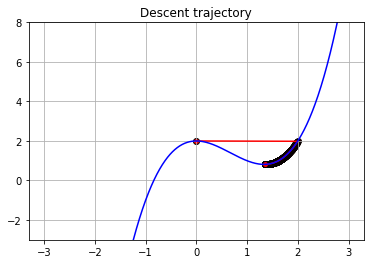

In [8]:
find_minimum_first_order(0.001)

local minimum:  1.3356881625009205
number of steps:  129


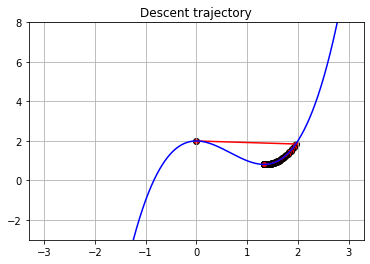

In [9]:
find_minimum_first_order(0.01)

local minimum:  1.3333495713163788
number of steps:  8


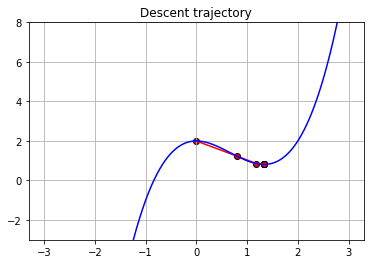

In [10]:
find_minimum_first_order(0.3)

In [18]:
find_minimum_first_order(0.6)

OverflowError: ignored

local minimum:  1.294744839667743
number of steps:  7


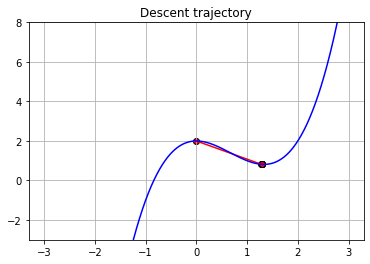

In [21]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3*lr)